# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV931"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv931')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv931/lv931-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 11:47:51,048 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
2049,MIPS_SPLICEOSOME,931,0.634804,0.006035,0.031293
2050,PID_TGFBRPATHWAY,931,0.708098,0.008138,0.039896


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP056295, SRP017138, SRP043080, SRP048759, SRP021191, SRP028594, SRP056197, SRP050272, SRP059735, SRP028554, SRP061932, SRP033266, SRP005279, SRP055390, SRP050493, SRP046233, SRP035679, SRP043033, SRP041885, SRP027358, SRP045500, SRP045352, SRP015360, SRP053046, 

In [19]:
lv_data.shape

(1932, 45)

In [20]:
lv_data.head()

tissue                           cell type  \
project   run                                                           
SRP056295 SRR1918758  Bone marrow  acute myeloid leukemia (AML) cells   
          SRR1918759  Bone marrow  acute myeloid leukemia (AML) cells   
          SRR1918756  Bone marrow  acute myeloid leukemia (AML) cells   
          SRR1918757  Bone marrow  acute myeloid leukemia (AML) cells   
          SRR1918754  Bone marrow  acute myeloid leukemia (AML) cells   

                     genotype treatment donor gender time  \
project   run                                               
SRP056295 SRR1918758      NaN       NaN   NaN    NaN  NaN   
          SRR1918759      NaN       NaN   NaN    NaN  NaN   
          SRR1918756      NaN       NaN   NaN    NaN  NaN   
          SRR1918757      NaN       NaN   NaN    NaN  NaN   
          SRR1918754      NaN       NaN   NaN    NaN  NaN   

                     individual identifier monozygotic twin relationship  \
project   run                                                              
SRP056295 SRR1918758                   NaN                           NaN   
          SRR1918759                   NaN                           NaN   
          SRR1918756                   NaN                           NaN   
          SRR1918757                   NaN                           NaN   
          SRR1918754                   NaN                           NaN   

                     disease  ... race samplename smoker  \
project   run                 ...                          
SRP056295 SRR1918758     NaN  ...  NaN        NaN    NaN   
          SRR1918759     NaN  ...  NaN        NaN    NaN   
          SRR1918756     NaN  ...  NaN        NaN    NaN   
          SRR1918757     NaN  ...  NaN        NaN    NaN   
          SRR1918754     NaN  ...  NaN        NaN    NaN   

                     time since last flare (months) time since steroid dose  \
project   run                                                                 
SRP056295 SRR1918758                            NaN                     NaN   
          SRR1918759                            NaN                     NaN   
          SRR1918756                            NaN                     NaN   
          SRR1918757                            NaN                     NaN   
          SRR1918754                            NaN                     NaN   

                     time since symptom onset (yrs) years since diagnosis  \
project   run                                                               
SRP056295 SRR1918758                            NaN                   NaN   
          SRR1918759                            NaN                   NaN   
          SRR1918756                            NaN                   NaN   
          SRR1918757                            NaN                   NaN   
          SRR1918754                            NaN                   NaN   

                     agent  Sex     LV931  
project   run                              
SRP056295 SRR1918758   NaN  NaN  0.300555  
          SRR1918759   NaN  NaN  0.301740  
          SRR1918756   NaN  NaN  0.372353  
          SRR1918757   NaN  NaN  0.372030  
          SRR1918754   NaN  NaN  0.315455  

[5 rows x 45 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

in vitro culture                           0.244410
donor                                      0.139964
time                                       0.139964
genotype                                   0.131958
treatment                                  0.114311
cytogenetics                               0.069754
mutation                                   0.069754
type of chronic myelomonocytic leukemia    0.069754
bcp all subtype                            0.061439
resonse to decitabine                      0.060590
cell type                                  0.056178
all lineage                                0.056146
disease state                              0.051575
tissue                                     0.047787
gender                                     0.044061
disease                                    0.031704
age                                        0.028859
agent                                      0.023872
tissues                                    0.020706
modulating a

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type       0.056178
tissue          0.047787
cell subtype    0.014120
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "cell subtype",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[3]

cell type             tissue  \
project   run                                                                 
SRP028554 SRR948497                                  NaN        bone marrow   
SRP061932 SRR2141370                        CD4+ T cells         cord blood   
SRP056295 SRR1918695  acute myeloid leukemia (AML) cells  Heparinised blood   
          SRR1918696  acute myeloid leukemia (AML) cells  Heparinised blood   
SRP033266 SRR1036041              acute myeloid leukemia  Heparinised blood   
SRP061932 SRR2141371                        CD4+ T cells         cord blood   
SRP043080 SRR1373461                                PBMC                NaN   
SRP033266 SRR1036130              acute myeloid leukemia  Heparinised blood   
          SRR1036125              acute myeloid leukemia  Heparinised blood   
          SRR1036128              acute myeloid leukemia  Heparinised blood   
          SRR1036131              acute myeloid leukemia  Heparinised blood   
SRP056295 SRR1918614  acute myeloid leukemia (AML) cells  Heparinised blood   
SRP033266 SRR1036132              acute myeloid leukemia  Heparinised blood   
          SRR1036129              acute myeloid leukemia  Heparinised blood   
          SRR1036127              acute myeloid leukemia  Heparinised blood   
SRP056295 SRR1918613  acute myeloid leukemia (AML) cells  Heparinised blood   
          SRR1918746  acute myeloid leukemia (AML) cells  Heparinised blood   
          SRR1918727  acute myeloid leukemia (AML) cells        Bone marrow   
SRP033266 SRR1036126              acute myeloid leukemia  Heparinised blood   
SRP056295 SRR1918745  acute myeloid leukemia (AML) cells  Heparinised blood   
          SRR1918728  acute myeloid leukemia (AML) cells        Bone marrow   
SRP005279 SRR091652                                  NaN        Bone marrow   
SRP056295 SRR1918675  acute myeloid leukemia (AML) cells  Heparinised blood   
          SRR1918676  acute myeloid leukemia (AML) cells  Heparinised blood   
SRP021191 SRR830954                           CD14 cells                NaN   

                     cell subtype     LV931  
project   run                                
SRP028554 SRR948497           NaN  0.789096  
SRP061932 SRR2141370          NaN  0.788928  
SRP056295 SRR1918695          NaN  0.787564  
          SRR1918696          NaN  0.786479  
SRP033266 SRR1036041          NaN  0.781820  
SRP061932 SRR2141371          NaN  0.760716  
SRP043080 SRR1373461          NaN  0.760076  
SRP033266 SRR1036130          NaN  0.759355  
          SRR1036125          NaN  0.759207  
          SRR1036128          NaN  0.758832  
          SRR1036131          NaN  0.758795  
SRP056295 SRR1918614          NaN  0.758590  
SRP033266 SRR1036132          NaN  0.758417  
          SRR1036129          NaN  0.757830  
          SRR1036127          NaN  0.757681  
SRP056295 SRR1918613          NaN  0.757201  
          SRR1918746          NaN  0.756385  
          SRR1918727          NaN  0.756236  
SRP033266 SRR1036126          NaN  0.756210  
SRP056295 SRR1918745          NaN  0.755959  
          SRR1918728          NaN  0.755636  
SRP005279 SRR091652           NaN  0.748322  
SRP056295 SRR1918675          NaN  0.747162  
          SRR1918676          NaN  0.747049  
SRP021191 SRR830954           NaN  0.736694

In [26]:
# # what is there in these projects?
# lv_data.loc[["SRP048222"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).sort_values(LV_NAME, ascending=False).head(10)

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type     LV931
project   run                                                     
SRP056295 SRR1918560  acute myeloid leukemia (AML) cells  1.072961
          SRR1918559  acute myeloid leukemia (AML) cells  1.071910
SRP017138 SRR616079                      NOT CATEGORIZED  1.059257
SRP043080 SRR1373464                                PBMC  1.033864
SRP056295 SRR1918487  acute myeloid leukemia (AML) cells  1.004104
          SRR1918488  acute myeloid leukemia (AML) cells  1.003725
SRP043080 SRR1373449                                PBMC  0.994688
SRP017138 SRR616077                      NOT CATEGORIZED  0.970944
SRP056295 SRR1918363  acute myeloid leukemia (AML) cells  0.968299
          SRR1918364  acute myeloid leukemia (AML) cells  0.965907
          SRR1918394  acute myeloid leukemia (AML) cells  0.963353
SRP048759 SRR1608637              acute myeloid leukemia  0.963065
SRP056295 SRR1918393  acute myeloid leukemia (AML) cells  0.962881
SRP048759 SRR1608636              acute myeloid leukemia  0.956578
          SRR1608634              acute myeloid leukemia  0.952677
          SRR1608635              acute myeloid leukemia  0.951694
SRP021191 SRR830952                           CD14 cells  0.943728
          SRR830948                           CD14 cells  0.943218
SRP056295 SRR1918459  acute myeloid leukemia (AML) cells  0.943164
          SRR1918460  acute myeloid leukemia (AML) cells  0.942857

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "whole blood": "Whole blood",
            "monocyte": "Monocyte",
            "bone marrow": "Bone marrow",
            "acute myeloid leukemia (AML) cells": "Acute myeloid leukemia",
            "acute myeloid leukemia": "Acute myeloid leukemia",
        }
    }
)

In [34]:
# add also tissue information to these projects
_srp_code = "SRP056295"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


_srp_code = "SRP048759"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-34ae5074f2a8>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-34-34ae5074f2a8>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

19

In [40]:
attr_order[:5]

['Acute myeloid leukemia (Heparinised blood)',
 'PBMC',
 'CD14 cells',
 'Acute myeloid leukemia (Bone marrow)',
 'blood']

## Plot

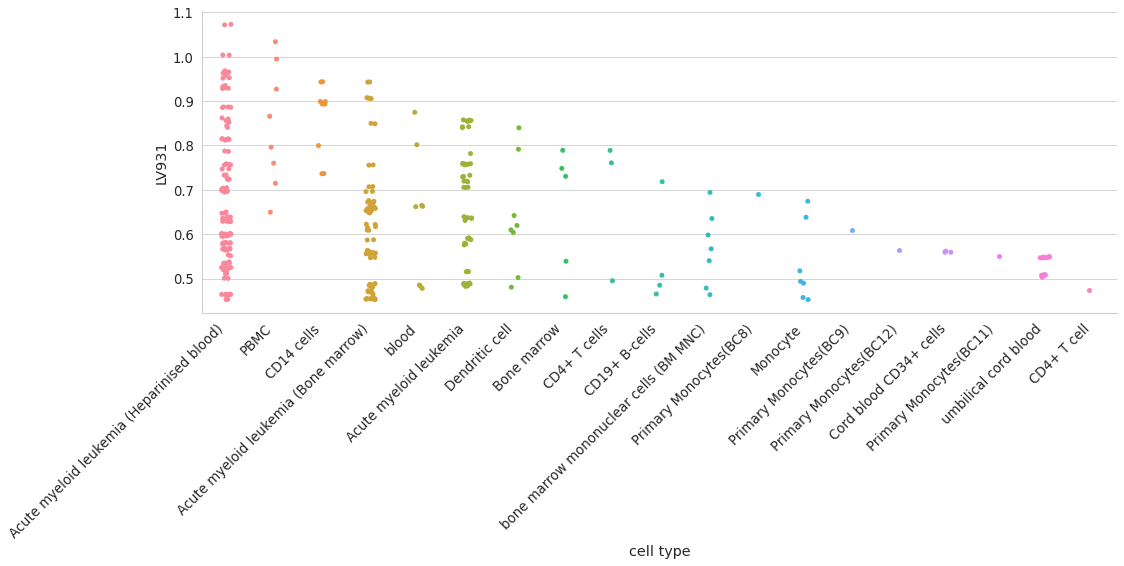

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("acute my")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP056295"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)